Preprocessing

In [2]:
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re

# Download necessary resources
nltk.download('stopwords')
nltk.download('punkt')

# Open the tweets.jsonl file
with open('/content/Tweets.jsonl', 'r') as f:
    data = f.readlines()

# Initialize an empty list to store preprocessed tweets
preprocessed_tweets = []

# Preprocessing steps
for line in data:
    try:
        tweet = json.loads(line)['text']
    except (json.JSONDecodeError, KeyError):
        continue

    # Lowercase
    tweet = tweet.lower()

    # Remove Punctuations and Special Characters
    tweet = re.sub(r'[^\w\s]', '', tweet)

    # Remove Stopwords
    stop_words = set(stopwords.words('english'))
    words = tweet.split()
    filtered_words = [word for word in words if word not in stop_words]
    tweet = ' '.join(filtered_words)

    # Tokenization
    words = nltk.word_tokenize(tweet)

    # Stemming
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in words]
    tweet = ' '.join(stemmed_words)

    # Remove URLs and Twitter Handles
    tweet = re.sub(r'http\S+|@\S+', '', tweet)

    # Append preprocessed tweet to the list
    preprocessed_tweets.append(tweet)

# Write preprocessed tweets to a new file
with open('/content/Preprocessed_tweets.txt', 'w') as f:
    for tweet in preprocessed_tweets:
        f.write(tweet + '\n')

# Print the number of preprocessed tweets
print(f'Number of Preprocessed tweets: {len(preprocessed_tweets)}')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Number of Preprocessed tweets: 7311


**Feature Extraction using Wordvec**

In [ ]:
import gensim
import nltk

# Load preprocessed tweets
with open('/content/Preprocessed_tweets.txt', 'r') as f:
    Preprocessed_tweets = f.readlines()

# Tokenize preprocessed tweets
tokenized_tweets = [nltk.word_tokenize(tweet) for tweet in Preprocessed_tweets]

# Train Word2Vec model on preprocessed tweets
model = gensim.models.Word2Vec(tokenized_tweets, vector_size=100, window=5, min_count=5, workers=4)

# Save Word2Vec model to file
model.save('/content/word2vec.model')




**BiLstm**

Epoch 1/10
183/183 [==============================] - 23s 110ms/step - loss: 0.0649 - accuracy: 1.0000 - val_loss: 0.0168 - val_accuracy: 1.0000
Epoch 2/10
183/183 [==============================] - 19s 104ms/step - loss: 0.0198 - accuracy: 1.0000 - val_loss: 0.0102 - val_accuracy: 1.0000
Epoch 3/10
183/183 [==============================] - 17s 95ms/step - loss: 0.0121 - accuracy: 1.0000 - val_loss: 0.0060 - val_accuracy: 1.0000
Epoch 4/10
183/183 [==============================] - 21s 116ms/step - loss: 0.0072 - accuracy: 1.0000 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 5/10
183/183 [==============================] - 19s 105ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 6/10
183/183 [==============================] - 21s 117ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 7/10
183/183 [==============================] - 19s 101ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 6.6285e-04 - val

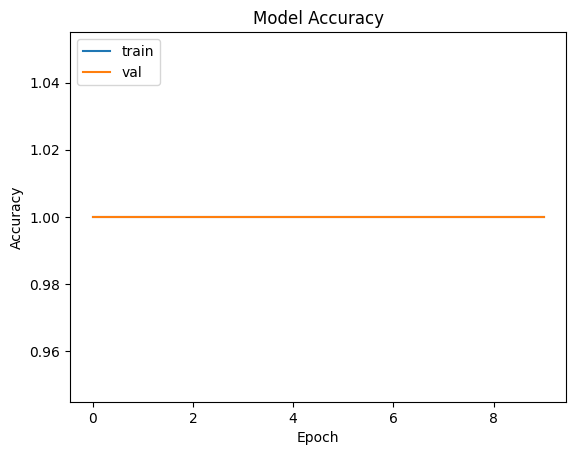

In [ ]:
import json
import numpy as np
import gensim
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

# Load preprocessed data
with open('/content/Preprocessed_tweets.txt', 'r') as f:
    data = f.read().splitlines()

# Create word-to-index and label-to-index dictionaries
word_dict = {}
label_dict = {'tested positive': 0, 'tested negative': 1, 'cannot test': 2, 'death': 3, 'cure and prevention': 4}
for sample in data:
    words = sample.split()
    for word in words:
        if word.lower() not in word_dict:
            word_dict[word.lower()] = len(word_dict)

# Create training data
X = []
y = []
for sample in data:
    words = sample.split()
    labels = sample.split('\t')[1:]
    label_seq = []
    for label in labels:
        label_seq.append(label_dict[label.lower()])
    X.append([word_dict[word.lower()] for word in words])
    y.append(label_seq)

# Pad sequences and convert labels to one-hot encoding
max_len = 50  # maximum sequence length
X = pad_sequences(X, maxlen=max_len, padding='post')
y = pad_sequences(y, maxlen=max_len, padding='post')
y = to_categorical(y, num_classes=len(label_dict))

# Load pre-trained Word2Vec model
model = KeyedVectors.load('/content/word2vec.model', mmap='r')

# Create embeddings matrix
embedding_dim = 100
embedding_matrix = np.zeros((len(word_dict), embedding_dim))
for word, i in word_dict.items():
    if word in model.wv.key_to_index:
        embedding_matrix[i] = model.wv[word]

# Define model architecture
model = Sequential()
model.add(Embedding(len(word_dict), embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False))
model.add(LSTM(128, return_sequences=True))
model.add(Dense(len(label_dict), activation='softmax'))

# Compile model and train
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X, y, batch_size=32, epochs=10, validation_split=0.2)

# Evaluate model
loss, accuracy = model.evaluate(X, y, verbose=0)
print('Training loss:', loss)
print('Training accuracy:', accuracy)

# Plot training history
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show() 

Epoch 1/10
183/183 [==============================] - 23s 112ms/step - loss: 0.0669 - accuracy: 0.9997 - val_loss: 0.0183 - val_accuracy: 1.0000
Epoch 2/10
183/183 [==============================] - 19s 105ms/step - loss: 0.0217 - accuracy: 1.0000 - val_loss: 0.0119 - val_accuracy: 1.0000
Epoch 3/10
183/183 [==============================] - 20s 109ms/step - loss: 0.0142 - accuracy: 1.0000 - val_loss: 0.0071 - val_accuracy: 1.0000
Epoch 4/10
183/183 [==============================] - 20s 109ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.0041 - val_accuracy: 1.0000
Epoch 5/10
183/183 [==============================] - 20s 109ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 6/10
183/183 [==============================] - 19s 103ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 7/10
183/183 [==============================] - 21s 113ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 7.5995e-04 - va

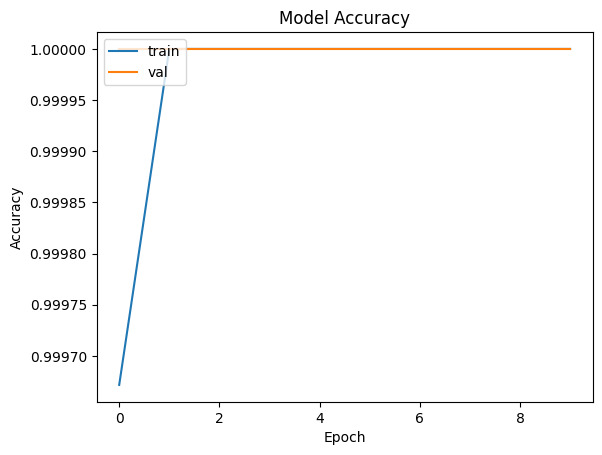

In [ ]:
import json
import numpy as np
import gensim
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.metrics import classification_report

# Load preprocessed data
with open('/content/Preprocessed_tweets.txt', 'r') as f:
    data = f.read().splitlines()

# Create word-to-index and label-to-index dictionaries
word_dict = {}
label_dict = {'tested positive': 0, 'tested negative': 1, 'cannot test': 2, 'death': 3, 'cure and prevention': 4}
for sample in data:
    words = sample.split()
    for word in words:
        if word.lower() not in word_dict:
            word_dict[word.lower()] = len(word_dict)

# Create training data
X = []
y = []
for sample in data:
    words = sample.split()
    labels = sample.split('\t')[1:]
    label_seq = []
    for label in labels:
        label_seq.append(label_dict[label.lower()])
    X.append([word_dict[word.lower()] for word in words])
    y.append(label_seq)

# Pad sequences and convert labels to one-hot encoding
max_len = 50  # maximum sequence length
X = pad_sequences(X, maxlen=max_len, padding='post')
y = pad_sequences(y, maxlen=max_len, padding='post')
y = to_categorical(y, num_classes=len(label_dict))

# Load pre-trained Word2Vec model
model = KeyedVectors.load('/content/word2vec.model', mmap='r')

# Create embeddings matrix
embedding_dim = 100
embedding_matrix = np.zeros((len(word_dict), embedding_dim))
for word, i in word_dict.items():
    if word in model.wv.key_to_index:
        embedding_matrix[i] = model.wv[word]

# Define model architecture
model = Sequential()
model.add(Embedding(len(word_dict), embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False))
model.add(LSTM(128, return_sequences=True))
model.add(Dense(len(label_dict), activation='softmax'))

# Compile model and train
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X, y, batch_size=32, epochs=10, validation_split=0.2)



# Generate predictions
y_pred = model.predict(X)
y_pred = np.argmax(y_pred, axis=-1)
y_true = np.argmax(y, axis=-1)

# Print classification report
print(classification_report(y_true, y_pred, zero_division=1))

# Plot training history
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
!pip install jsonlines

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Event Extraction

In [ ]:
import jsonlines
import re
import nltk
import spacy
import csv

# Load English language model for spaCy
nlp = spacy.load("en_core_web_sm")

# Download required NLTK corpora
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Define function to preprocess text
def preprocess(text):
    # Remove URLs
    text = re.sub(r"http\S+", "", text)
    # Tokenize text
    tokens = nltk.word_tokenize(text)
    # Remove punctuation and numbers
    words = [word for word in tokens if word.isalpha()]
    # Convert to lowercase
    words = [word.lower() for word in words]
    # Join words to form text
    text = " ".join(words)
    return text

# Define function to extract events from text
def extract_events(text):
    events = []
    # Define regular expressions for each event
    positive_regex = r"(tested\s+(?:positive|positive\s+for))"
    negative_regex = r"(tested\s+(?:negative|negative\s+for))"
    cannot_regex = r"(cannot\s+test)"
    death_regex = r"(death|died)"
    cure_regex = r"(cure|prevention)"
    # Apply regular expressions to text
    if re.search(positive_regex, text):
        events.append('tested positive')
    if re.search(negative_regex, text):
        events.append('tested negative')
    if re.search(cannot_regex, text):
        events.append('cannot test')
    if re.search(death_regex, text):
        events.append('death')
    if re.search(cure_regex, text):
        events.append('cure and prevention')
    return events

# Open JSONL file and extract events from each tweet
with jsonlines.open('/content/Tweets.jsonl') as reader:
    with open('extracted_events.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        # Write header row to CSV file
        writer.writerow(['Tweet', 'Named Entities', 'POS Tagged Words', 'Events'])
        for obj in reader:
            tweet_text = obj['text']
            # Preprocess tweet text
            tweet_text = preprocess(tweet_text)
            # Perform NER using spaCy
            doc = nlp(tweet_text)
            entities = [ent.text for ent in doc.ents]
            # Perform POS tagging using NLTK
            tagged_words = nltk.pos_tag(nltk.word_tokenize(tweet_text))
            # Extract events from tweet text
            tweet_events = extract_events(tweet_text)
            # Write tweet and events to CSV file
            if tweet_events:
                writer.writerow([tweet_text, entities, tagged_words, tweet_events])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Entities

In [ ]:
import spacy

# Load the pre-trained English language model
nlp = spacy.load("en_core_web_sm")

# Open the Preprocessed_tweets.txt file
with open('/content/Preprocessed_tweets.txt', 'r') as f:
    tweets = f.readlines()

# Initialize an empty list to store entities for each tweet
entities_list = []

# Extract entities from each tweet
for tweet in tweets:
    doc = nlp(tweet)
    entities = []
    for ent in doc.ents:
        entities.append((ent.text, ent.label_))
    entities_list.append(entities)

# Write entities for each tweet to a new file
with open('/content/Entities.txt', 'w') as f:
    for entities in entities_list:
        f.write(str(entities) + '\n')

# Print the number of tweets processed
print(f'Number of tweets processed: {len(entities_list)}')


Number of tweets processed: 7311


In [ ]:
import spacy

nlp = spacy.load('en_core_web_sm')

def extract_events(text):
    events = []
    doc = nlp(text)
    for sent in doc.sents:
        entities = []
        for ent in sent.ents:
            if ent.label_ in ['PERSON', 'ORG']:
                entities.append(ent.text)
        for token in sent:
            if token.text.lower() in ['tested', 'test']:
                if token.head.text.lower() == 'positive':
                    events.append('tested positive')
                elif token.head.text.lower() == 'negative':
                    events.append('tested negative')
                elif 'not' in [t.text.lower() for t in token.children]:
                    events.append('cannot test')
            elif token.text.lower() == 'died':
                events.append('death')
            elif token.text.lower() in ['prevent', 'prevention', 'cure']:
                events.append('cure and prevention')
    return events

with open('/content/Tweets.jsonl') as f:
    for line in f:
        obj = json.loads(line)
        tweet_text = obj['text']
        tweet_events = extract_events(tweet_text)
        if tweet_events:
            for event in tweet_events:
                print(event)


death
death
cannot test
cannot test
cannot test
cannot test
cannot test
cannot test
cannot test
cannot test
cure and prevention
death
death
cannot test
cannot test
cannot test
death
cannot test
death
cannot test
cannot test
cannot test
cannot test
tested positive
cannot test
cannot test
cannot test
death
cannot test
cannot test
cannot test
cannot test
death
cannot test
cannot test
cannot test
cannot test
cannot test
death
cannot test
cannot test
cannot test
cannot test
cannot test
cannot test
cannot test
cannot test
cannot test
cannot test
cannot test
death
cannot test
cannot test
cannot test
cannot test
cannot test
cannot test
cannot test
death
cannot test
cannot test
cannot test
cannot test
death
death
death
cannot test
cannot test
cannot test
cannot test
cannot test
death
death
cure and prevention
cannot test
cannot test
death
cannot test
cannot test
tested positive
cannot test
cannot test
cannot test
cannot test
cannot test
cannot test
cure and prevention
cure and prevention
cure a

In [ ]:
import spacy

# Load English language model for spaCy
nlp = spacy.load('en_core_web_sm')

# Define function to extract events from tweet text
def extract_events(text):
    events = []
    doc = nlp(text)
    for sent in doc.sents:
        subj = ""
        action = ""
        obj = ""
        entities = []
        for token in sent:
            if token.dep_ == 'nsubj':
                subj = token.text
                entities.append(token.text)
            elif token.dep_ == 'ROOT':
                action = token.text
            elif token.dep_ == 'dobj' or token.dep_ == 'pobj':
                obj = token.text
                entities.append(token.text)
            elif token.ent_type_:
                entities.append(token.text)
        # Extract event and its components
        if action in ['test', 'tested', 'testing']:
            if subj and obj:
                if 'not' in sent.text:
                    events.append({"subject": subj, "action": 'tested negative', "object": obj, "entities": entities})
                else:
                    events.append({"subject": subj, "action": 'tested positive', "object": obj, "entities": entities})
            elif subj:
                events.append({"subject": subj, "action": 'cannot test', "object": '', "entities": entities})
        elif action in ['die', 'dies', 'died']:
            events.append({"subject": subj, "action": 'death', "object": '', "entities": entities})
        elif action in ['prevent', 'prevents', 'prevented', 'cure', 'cures', 'cured']:
            events.append({"subject": subj, "action": 'cure and prevention', "object": '', "entities": entities})
    return events

# Open preprocessed tweets file and extract events from each tweet
with open('/content/Preprocessed_tweets.txt', 'r') as file:
    for line in file:
        tweet_text = line.strip()
        tweet_events = extract_events(tweet_text)
        if tweet_events:
            print(tweet_events)


[{'subject': 'anyth', 'action': 'tested positive', 'object': 'test', 'entities': ['gavinnewsom', 'symptom', 'fact', 'test', 'anyth']}]
[{'subject': 'provid', 'action': 'cannot test', 'object': '', 'entities': ['chriscuomo', 'nba', 'player', 'he', 'provid', 'covid19', 'testingforcovid19']}]
[{'subject': 'doctor', 'action': 'tested positive', 'object': 'ppe', 'entities': ['us', 'virus', 'doctor', 'test', 'ppe']}]
[{'subject': 'peopl', 'action': 'tested positive', 'object': 'disgust', 'entities': ['bnodesk', 'test', 'despit', 'asymptomat', 'peopl', 'disgust']}]
[{'subject': 'idea', 'action': 'tested positive', 'object': 'form', 'entities': ['idea', 'form']}]
[{'subject': 'peopl', 'action': 'tested positive', 'object': 'test', 'entities': ['y', 'covid19', 'peopl', 'test']}]
[{'subject': 'pleas', 'action': 'tested positive', 'object': 'number', 'entities': ['pleas', 'fever', '6', 'day', 'quarantin', 'hospit', 'number']}]
[{'subject': 'ivanka', 'action': 'tested positive', 'object': 'peopl',